# COVID-19 en France

Kelun Chai, Djaber Solimani

In [59]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import sys
import os
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
#import geopandas as gpd

try:
    from data.France_data import *
    from visual.Set_plot import *
    from data.World_data import *
    from model.sir import *
    from model.seir import *
    from model.seird import *
except ImportError:
    print('Import failed.')

set_style()
set_pandas_display_options()

In [60]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1)
    ax.plot(t, S, 'b', label='Susceptible')
    ax.plot(t, E, 'y', label='Exposed')
    ax.plot(t, I, 'r', label='Infected')
    ax.plot(t, R, 'g', label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k',label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', label='Total')
        
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    legend = ax.legend(borderpad=2.0)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
  
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        ax.set_ylabel('Number (1000s)')
        ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        ax.set_ylabel('Number (1000s)')
        ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show()

## Données hospitalières relatives à l'épidémie de COVID-19
- Les données hospitalières relatives à l'épidémie du COVID-19 par département et sexe du patient.

In [61]:
data_hospitaliere = load_hospitaliere()
meta_hospitaliere = load_meta_hospitaliere()
print("Description:")
display(meta_hospitaliere)

Description:


,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,sexe,integer,Sexe,Sex,0
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimation ou soins intensifs,Number of people currently in resuscitation or critical care,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées à l'hôpital,Total amout of deaths at the hospital,0


In [62]:
data_hospitaliere.head(5)

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


- Situation globale en France

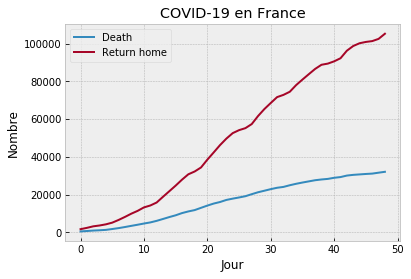

In [63]:
time=data_hospitaliere['jour'].unique()

def death_by_day():
    death=[]
    for i in time:
        num=data_hospitaliere.loc[data_hospitaliere.jour==i,['dc']].sum()
        death.append(num)
    return death

def rad_by_day():
    rad=[]
    for i in time:
        num=data_hospitaliere.loc[data_hospitaliere.jour==i,['rad']].sum()
        rad.append(num)
    return rad
    
def show_global():
    x=np.arange(len(time))
    y=death_by_day()
    y1=rad_by_day()
    plt.plot(x,y,label="Death")
    plt.plot(x,y1,label="Return home")
    plt.title("COVID-19 en France")
    plt.legend()
    plt.xlabel('Jour')
    plt.ylabel("Nombre")
    plt.show()

show_global()

/home/klchai/anaconda3/envs/algo/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


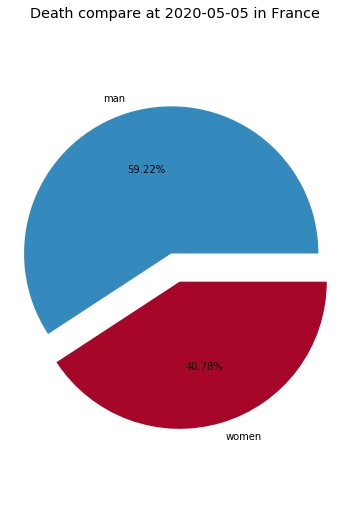

In [64]:
today = data_hospitaliere.loc[data_hospitaliere.jour=="2020-05-05"]
def death_man():
    death=[]
    num=today.loc[today.sexe==1,['dc']].sum()
    death.append(num)
    return death

def death_woman():
    death=[]
    num=today.loc[today.sexe==2,['dc']].sum()
    death.append(num)
    return death

man=death_man()
women=death_woman()
plt.figure(figsize=(6,9))
labels=['man','women']
sizes=[man,women]
explode=(0.2,0)
patches,text1,text2 = plt.pie(sizes, labels=labels, explode=explode,autopct = '%3.2f%%') 
plt.title("Death compare at 2020-05-05 in France")
plt.axis('equal')
plt.show()

- Situation à Paris

In [65]:
df_paris = data_hospitaliere[data_hospitaliere.dep=='75']

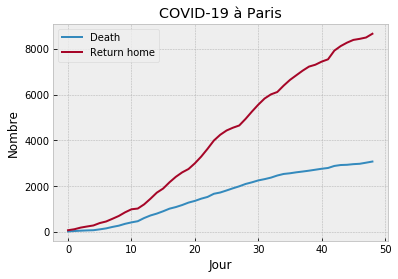

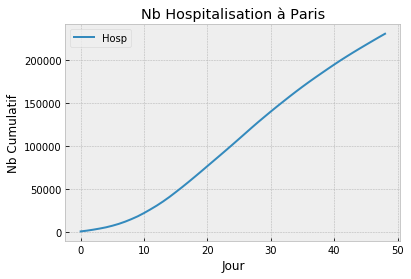

In [66]:
def death_in_paris():
    death=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['dc']].sum()
        death.append(num)
    return death

def rad_in_paris():
    rad=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['rad']].sum()
        rad.append(num)
    return rad

def hosp_in_paris():
    hosp=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['hosp']].sum()
        hosp.append(num)
    cum_hosp = np.array(hosp).cumsum()
    return cum_hosp

def show_global():
    x=np.arange(len(time))
    y=death_in_paris()
    y1=rad_in_paris()
    plt.plot(x,y,label="Death")
    plt.plot(x,y1,label="Return home")
    plt.title("COVID-19 à Paris")
    plt.legend()
    plt.xlabel("Jour")
    plt.ylabel("Nombre")
    plt.show()

def show_hosp_paris():
    x=np.arange(len(time))
    y=hosp_in_paris()
    plt.plot(x,y,label="Hosp")
    plt.title("Nb Hospitalisation à Paris")
    plt.legend()
    plt.xlabel("Jour")
    plt.ylabel("Nb Cumulatif")
    plt.show()
    
show_global()
show_hosp_paris()

### Afficher sur la carte

In [67]:
carte = gpd.read_file('visual/departements-version-simplifiee.geojson')

NameError: name 'gpd' is not defined

In [34]:
data = load_hospitaliere_etablissements()
df_today = data.loc[data.jour=="2020-05-05",['dep','nb']]
meta = load_meta_hospitaliere_etablissements()
meta.head(3)

,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,18/03/2020
2,nb,integer,Nombre cumulé de services hospitaliers ayant déclaré au moins un cas,Total amount of hospital services reporting at least one case,1


In [35]:
data_merge = carte.merge(df_today, left_on='code', right_on='dep', suffixes=('','_y')).drop('dep',axis=1)
# data_merge.head(5)

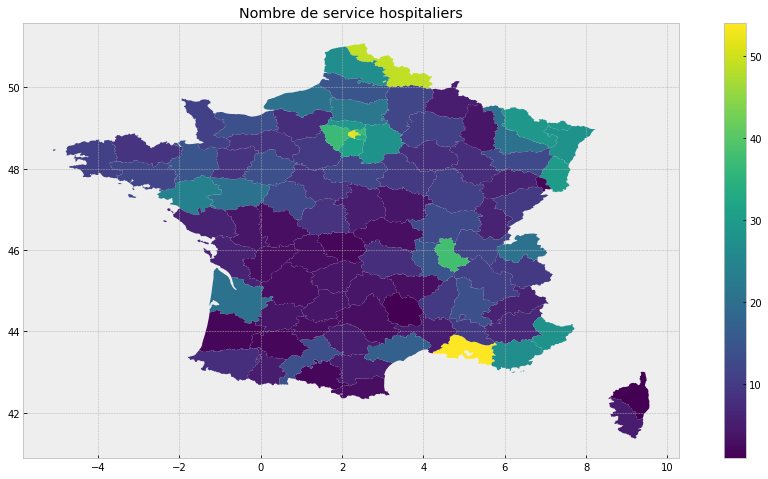

In [36]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 8)
data_merge.plot(column='nb',ax=ax,legend=True)
plt.title("Nombre de service hospitaliers")
plt.show()

## SIR Model

In [114]:
clean()

/home/klchai/workspace/ML_COVID-19/data/World_data.py:53: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
/home/klchai/workspace/ML_COVID-19/data/World_data.py:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']


### France

In [174]:
t = range(france.shape[0])
N = 67_000_000
I = france["Confirmed"].to_numpy()
sir = SIRModel()
params = sir.fit(t,N,I)
print("Params:",params)

/home/klchai/anaconda3/envs/algo/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/klchai/workspace/ML_COVID-19/model/sir.py:17: RuntimeWarning: overflow encountered in double_scalars
  dSdt = -beta * S * I / N
/home/klchai/workspace/ML_COVID-19/model/sir.py:18: RuntimeWarning: overflow encountered in double_scalars
  dIdt = beta * S * I / N - gamma * I
/home/klchai/workspace/ML_COVID-19/model/sir.py:19: RuntimeWarning: overflow encountered in double_scalars
  dRdt = gamma * I


Params: [1.2853194  1.17583419]


In [177]:
t = range(0,200)
old_t = range(france.shape[0])
S_n, I_n, R_n = sir.predict(t,old_t,N,I)

/home/klchai/anaconda3/envs/algo/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/klchai/workspace/ML_COVID-19/model/sir.py:17: RuntimeWarning: overflow encountered in double_scalars
  dSdt = -beta * S * I / N
/home/klchai/workspace/ML_COVID-19/model/sir.py:18: RuntimeWarning: overflow encountered in double_scalars
  dIdt = beta * S * I / N - gamma * I
/home/klchai/workspace/ML_COVID-19/model/sir.py:19: RuntimeWarning: overflow encountered in double_scalars
  dRdt = gamma * I


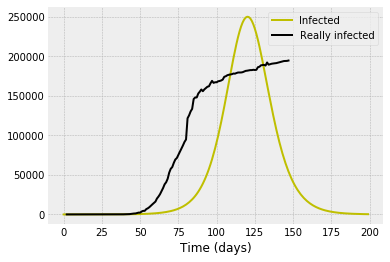

In [178]:
plottest(I_n, france)

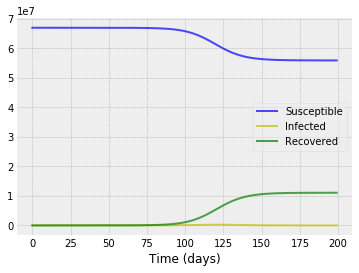

In [179]:
sir.plotsir(t,S_n,I_n,R_n)

## SEIR Model

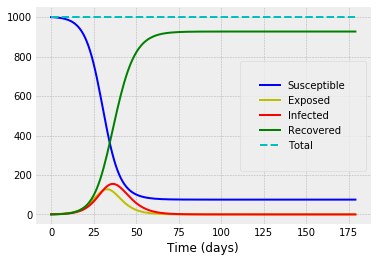

In [126]:
N = 1000
beta = 0.7
D = 4.0 
gamma = 1.0 / D
delta = 1.0 / 3.0
seir = SEIRModel(beta=beta, gamma=gamma, delta=delta)
t_p = range(0,180)
I=[0]
y0 = N-I[0], 2, I[0], 0
S_p,E_p,I_p,R_p = seir.predict(t_p,y0)
plotseird(t_p, S_p, E_p, I_p, R_p)

### France

In [180]:
df_france = load_france()
df_france.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
2,2020-01-24,France,2,0,0.0,2.0,2,0,0
3,2020-01-25,France,3,0,0.0,3.0,1,0,0
4,2020-01-26,France,3,0,0.0,3.0,0,0,0
5,2020-01-27,France,3,0,0.0,3.0,0,0,0
6,2020-01-28,France,4,0,0.0,4.0,1,0,0


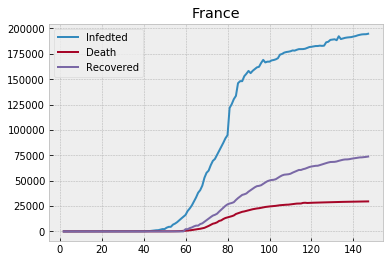

In [181]:
plt.plot(df_france["Confirmed"],label="Infedted")
plt.plot(df_france["Deaths"],label="Death")
plt.plot(df_france["Recovered"],label="Recovered")
plt.legend()
plt.title("France")
plt.show()

### Train model only on Infected

In [182]:
seir = SEIRModel()
N = 67_000_000
I = df_france["Confirmed"].to_numpy()
R = df_france["Recovered"].to_numpy()
t = range(df_france.shape[0])
print("Init:",seir.params)
seir.fit(t,N,I)
real_b, real_d, real_g = seir.params
print("After:",seir.params)

Init: (0.1, 0.1, 0.1)
After: (1.2763239130213992, 37.13327825466508, 1.1661555032938782)


#### Predict Future on 180days

In [183]:
t_p = range(0,180)
y0 = N-I[0], 2, I[0], 0
S_p,E_p,I_p,R_p = seir.predict(t_p,y0)

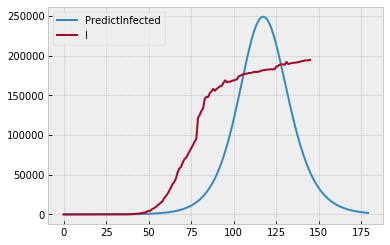

In [184]:
plt.plot(I_p,label="PredictInfected")
plt.plot(I,label="I")
plt.legend()
plt.show()

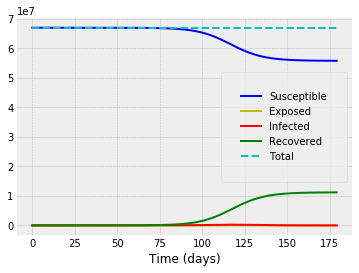

In [185]:
plotseird(t_p, S_p, E_p, I_p, R_p)

### Train model on Infected and Recovered

In [186]:
seir = SEIRModel()
N = 67_000_000
I = df_france["Confirmed"].to_numpy()
R = df_france["Recovered"].to_numpy()
t = range(df_france.shape[0])
print("Init:",seir.params)
seir.fit_NIR(t,N,I,R)
real_b, real_d, real_g = seir.params
print("After:",seir.params)

Init: (0.1, 0.1, 0.1)
After: (0.11439877243195898, 3.325957979441264, 0.030939848407518098)


#### Predict Future on 360days

In [187]:
t_p360 = range(0,360)
y0 = N-I[0], 2, I[0], 0
S_p360,E_p360,I_p360,R_p360 = seir.predict(t_p360,y0)

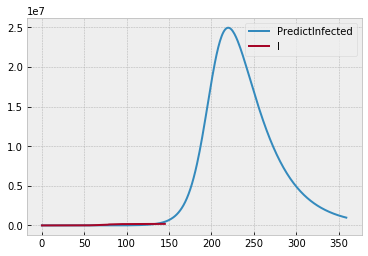

In [188]:
plt.plot(I_p360,label="PredictInfected")
plt.plot(I,label="I")
plt.legend()
plt.show()

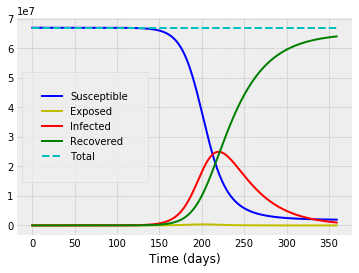

In [189]:
plotseird(t_p360, S_p360, E_p360, I_p360, R_p360)

### Predict based on data before confinement

In [190]:
df_france = load_france()
df_conf = df_france[df_france["Date"] < "2020-03-17"]
df_conf.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
2,2020-01-24,France,2,0,0.0,2.0,2,0,0
3,2020-01-25,France,3,0,0.0,3.0,1,0,0
4,2020-01-26,France,3,0,0.0,3.0,0,0,0
5,2020-01-27,France,3,0,0.0,3.0,0,0,0
6,2020-01-28,France,4,0,0.0,4.0,1,0,0


In [192]:
seirp = SEIRModel()
N = 67_000_000
I = df_conf["Confirmed"].to_numpy()
R = df_conf["Recovered"].to_numpy()
t = range(df_conf.shape[0])
print("Init:",seirp.params)
seirp.fit(t,N,I)
real_b, real_d, real_g = seirp.params
print("After:",seirp.params)

Init: (0.1, 0.1, 0.1)
After: (3.2436408436299073, 0.0678576366417665, 0.7057431049407399)


In [193]:
t_pc = range(0,360)
y0 = N-I[0], 2, I[0], 0
S_pc,E_pc,I_pc,R_pc = seirp.predict(t_pc,y0)

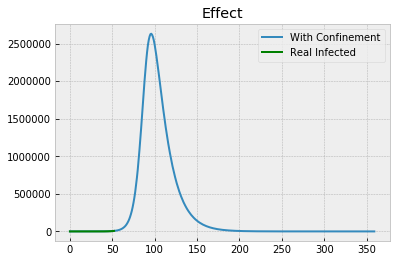

In [198]:
plt.title("Effect")
plt.plot(I_pc,label="With Confinement")
plt.plot(I,'g',label="Real Infected")
plt.legend()
plt.show()

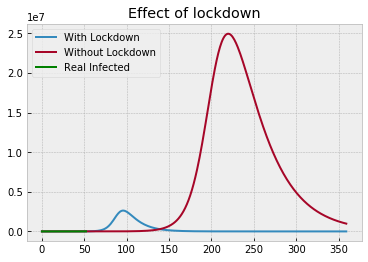

In [200]:
plt.title("Effect of lockdown")
plt.plot(I_pc,label="With Lockdown")
plt.plot(I_p360, label="Without Lockdown")
plt.plot(I,'g',label="Real Infected")
plt.legend()
plt.show()

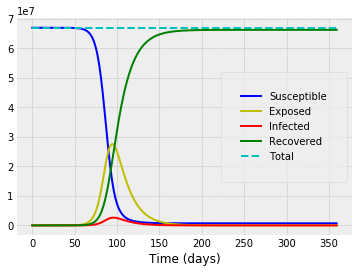

In [201]:
plotseird(t_pc, S_pc, E_pc, I_pc, R_pc)

## SEIRD model

In [265]:
df_france = load_france()
seird = SEIRDModel()

In [266]:
N = 67_000_000
I = df_france["Confirmed"].to_numpy()
R = df_france["Recovered"].to_numpy()
D = df_france["Deaths"].to_numpy()
t = range(df_france.shape[0])
print("Init:",seird.params)
seird.fit(t,N,I,R,D)
real_a, real_b, real_d, real_g, real_r = seird.params
print("After:",seird.params)

Init: (0.01, 0.1, 0.1, 0.1, 0.5)
After: (0.023270143741065796, 0.12770167722744027, 2.703284292219865, 0.030971952826752195, 0.5542418466067138)


### Predict on 200days

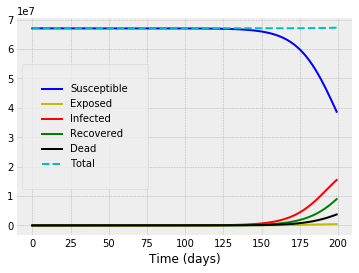

In [267]:
t_p200 = range(0,200)
y0 = N-I[0], 2, I[0], 0, 0
S_p200,E_p200,I_p200,R_p200,D_p200 = seird.predict(t_p200,y0)
plotseird(t_p200, S_p200, E_p200, I_p200, R_p200, D_p200)

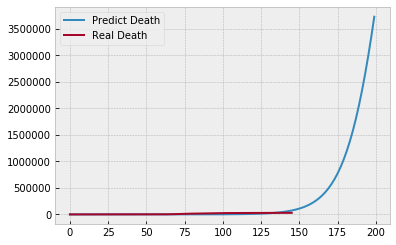

In [268]:
plt.plot(D_p200,label="Predict Death")
plt.plot(D,label="Real Death")
plt.legend()
plt.show()

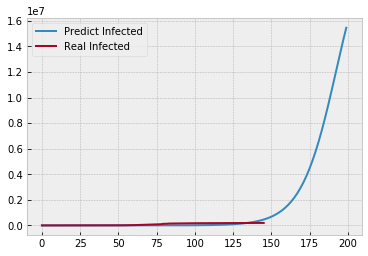

In [269]:
plt.plot(I_p200,label="Predict Infected")
plt.plot(I,label="Real Infected")
plt.legend()
plt.show()

### Predict on 300days

In [270]:
t_p300 = range(0,300)
y0 = N-I[0], 2, I[0], 0, 0
S_p300,E_p300,I_p300,R_p300,D_p300 = seird.predict(t_p300,y0)

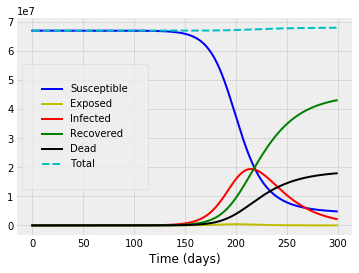

In [271]:
plotseird(t_p300, S_p300, E_p300, I_p300, R_p300, D_p300)

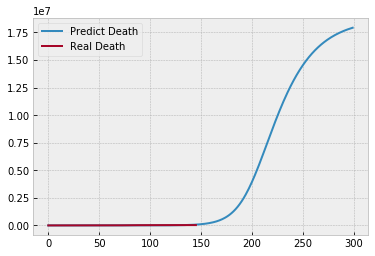

In [272]:
plt.plot(D_p300,label="Predict Death")
plt.plot(D,label="Real Death")
plt.legend()
plt.show()

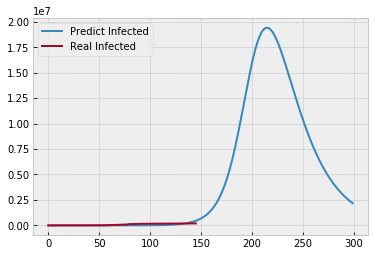

In [273]:
plt.plot(I_p300,label="Predict Infected")
plt.plot(I,label="Real Infected")
plt.legend()
plt.show()

### Predict based on data before confinement

In [274]:
df_france = load_france()
df_conf = df_france[df_france["Date"] < "2020-03-17"]
df_conf.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
2,2020-01-24,France,2,0,0.0,2.0,2,0,0
3,2020-01-25,France,3,0,0.0,3.0,1,0,0
4,2020-01-26,France,3,0,0.0,3.0,0,0,0
5,2020-01-27,France,3,0,0.0,3.0,0,0,0
6,2020-01-28,France,4,0,0.0,4.0,1,0,0


In [275]:
seirdp = SEIRDModel()
N = 67_000_000
I = df_conf["Confirmed"].to_numpy()
R = df_conf["Recovered"].to_numpy()
D = df_conf["Deaths"].to_numpy()
t = range(df_conf.shape[0])
print("Init:",seirdp.params)
seirdp.fit(t,N,I,R,D)
print("After:",seirdp.params)

Init: (0.01, 0.1, 0.1, 0.1, 0.5)
After: (0.005967403491536414, 18.640094956397494, 0.0015529856853676411, 0.0014155282529108018, 0.7036712318535931)


In [277]:
t_pc = range(0,200)
y0 = N-I[0], 2, I[0], 0, 0
S_pc,E_pc,I_pc,R_pc,D_pc = seirdp.predict(t_pc,y0)

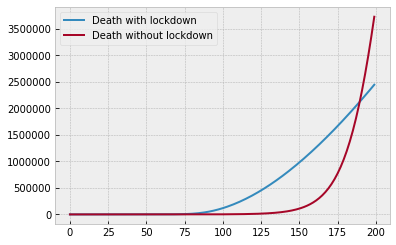

In [278]:
plt.plot(D_pc,label="Death with lockdown")
plt.plot(D_p200,label="Death without lockdown")
plt.legend()
plt.show()

FIN